In [1]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
experiment_type = 'reward-network-iii-exp-v2'
player_df = pd.read_csv(os.path.join('./data/experiment/processed/player.csv'))

In [3]:
min_player_score = player_df['player_score'].min()
max_player_score = player_df['player_score'].max()

# define plt color map
cmap = plt.cm.get_cmap('viridis')
# define color range
cnorm = plt.Normalize(vmin=min_player_score, vmax=max_player_score)
# map score to a color
cpick = plt.cm.ScalarMappable(norm=cnorm, cmap=cmap)

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_34884/3372780949.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


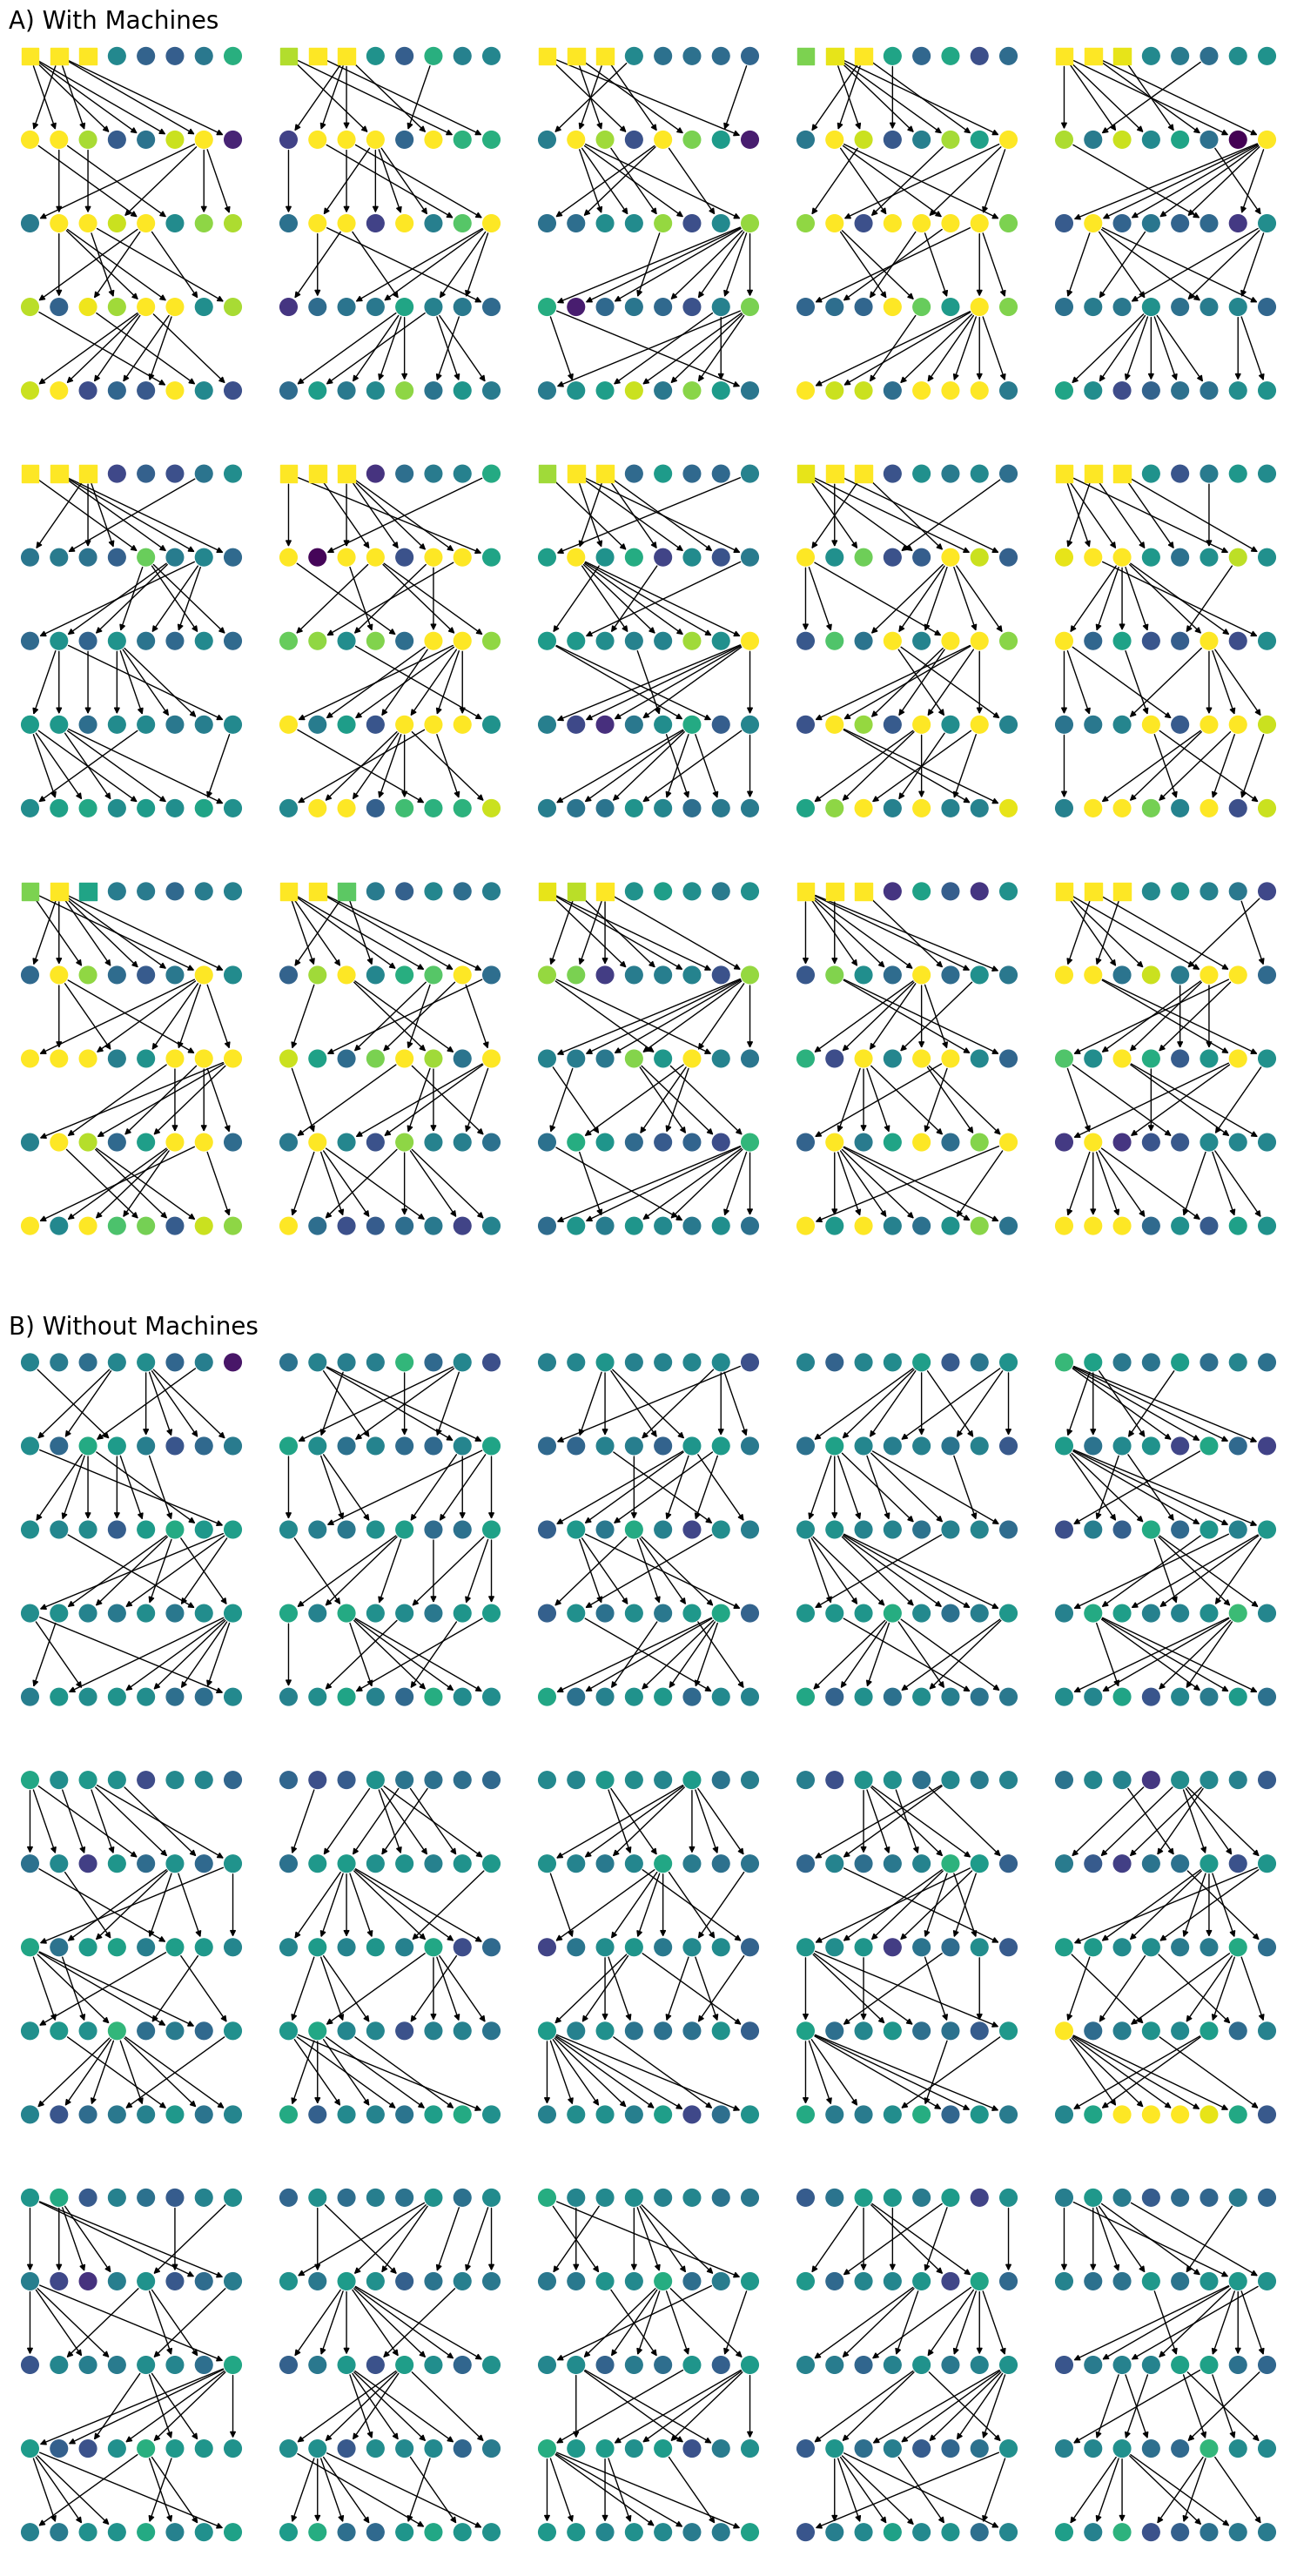

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec



# Create a dictionary to store node colors, positions, and labels
node_colors = {}
node_positions = {}
node_labels = {}
node_shapes = {}
node_size = 200

df = player_df[player_df['replication_idx'] < 15]

n_gen = df['generation'].max() + 1
max_per_gen = df['within_generation_idx'].max() + 1
n_ai = df.groupby(['replication_idx'])['ai_player'].sum().max()

n_reps = df['replication_idx'].max() + 1

rows = 6
cols = n_reps // (rows // 2)

# Create figure and define GridSpec
fig = plt.figure(figsize=(cols*3, rows*5))
gs = gridspec.GridSpec(rows + 1, cols, height_ratios=[1, 1, 1, 0.1, 1, 1, 1])  # Adjust the grid layout


# Iterate through the DataFrame
for (rep_idx, con), rep_df in df.groupby(['replication_idx', 'condition']):
    # Create a directed graph
    G = nx.DiGraph()
    row = rep_idx // cols + 4 if con == 'wo_ai' else rep_idx // cols
    col = rep_idx % cols
    ax = plt.subplot(gs[row, col])
    ax.axis('off')

    for idx, player in rep_df.iterrows():
        session_id = str(player['session_id'])
        # Add nodes
        G.add_node(session_id, label=player['session_name'])
        # Assign color
        node_colors[session_id] = mcolors.to_hex(cpick.to_rgba(player['player_score']))
        x_shift = 0
        y_shift = n_gen
        node_positions[session_id] = ((player['within_generation_idx'] + x_shift), (y_shift - player['generation']))
        # Add labels
        node_labels[session_id] = player['session_name']
        # Assign shapes
        node_shapes[session_id] = 's' if player['ai_player'] else 'o'

        # Add edges
        if not pd.isna(player['advisor']):
            advisor_id = str(player['advisor'])
            G.add_edge(advisor_id, str(player['session_id']))
            if advisor_id not in node_colors:
                # Assign a default color if advisor_id is not in player_df
                node_colors[advisor_id] = 'gray'

    # Generate a list of colors for each node in the graph
    final_node_colors = [node_colors[node] for node in G.nodes()]

    # Draw the network
    for shape in set(node_shapes.values()):
        # Filter nodes by shape
        filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
        nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes,
                            node_color=[node_colors[node] for node in filtered_nodes],
                            node_shape=shape, node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)
    # nx.draw_networkx_labels(G, node_positions, labels=node_labels)

fig.text(0.01, 0.98, 'A) With Machines', ha='left', va='center', fontsize=20)
fig.text(0.01, 0.48, 'B) Without Machines', ha='left', va='center', fontsize=20)

file_name = os.path.join('plots',experiment_type,'network.png')
os.makedirs(os.path.dirname(file_name), exist_ok=True)
plt.tight_layout()
fig.subplots_adjust(top=0.98, right=0.99)
plt.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.show()

In [5]:
cols

5

In [6]:
plots = [
    {
        'replication_idx': 0,
        'condition': 'w_ai',
        'title': 'A) AI Populations',
        'secondary_title': '9x',
        'row': 0,
        'col': 0
    },
    {
        'replication_idx': 1,
        'condition': 'w_ai',
        # 'title': 'B) AI Trees - Lost',
        'title': '',
        'secondary_title': '6x',
        'row': 0,
        'col': 1
    },
    {
        'replication_idx': 0,
        'condition': 'wo_ai',
        'title': 'B) Human Populations',
        'secondary_title': '14x',
        'row': 0,
        'col': 3
    },
    {
        'replication_idx': 9,
        'condition': 'wo_ai',
        # 'title': 'D) AI Trees - Discovered',
        'title': '',
        'secondary_title': '1x',
        'row': 0,
        'col': 4
    }
]

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_34884/1221983014.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


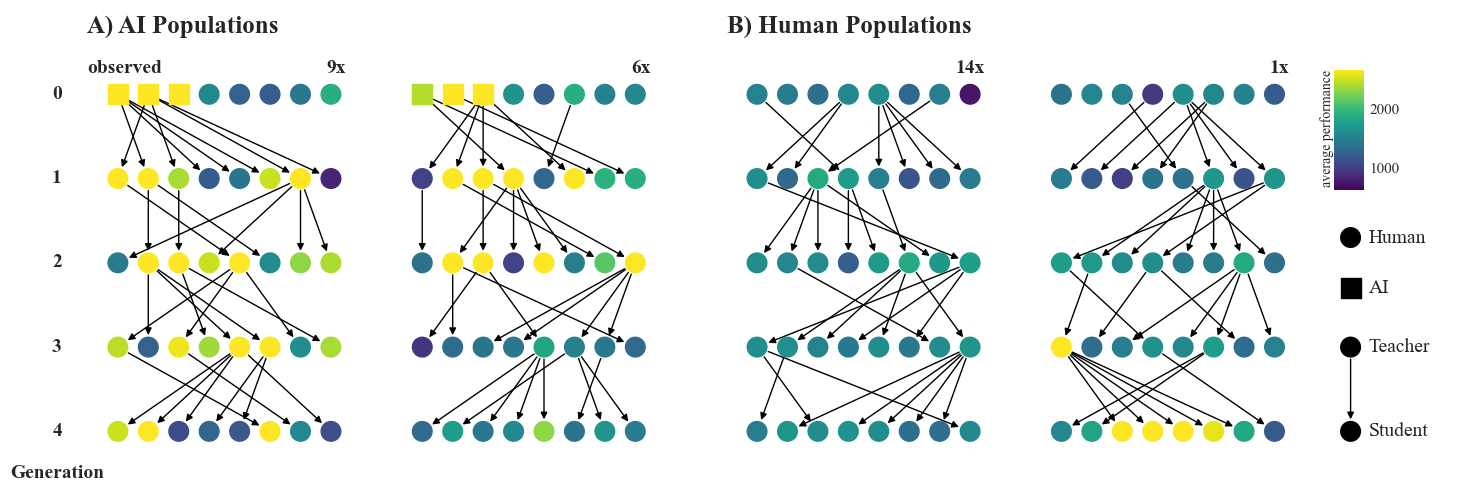

In [59]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'FreeSans']


# Create a dictionary to store node colors, positions, and labels
node_colors = {}
node_positions = {}
node_labels = {}
node_shapes = {}
node_size = 200

n_gen = player_df['generation'].max() + 1

player_df['within_generation_idx_per_tree'] = player_df.groupby(['replication_idx', 'condition', 'generation'])['within_generation_idx'].rank(method='first', ascending=True) - 1

cols = 4
rows = 1

# Create figure and define GridSpec
fig = plt.figure(figsize=((cols+1)*3, rows*5))
gs = gridspec.GridSpec(1, 7, width_ratios=[0.1, 1, 1, 0.1, 1, 1, 0.5])  # Adjust the grid layout


def plot_tree(df, n_gen, node_size, ax):
    G = nx.DiGraph()
    for idx, player in df.iterrows():
        session_id = str(player['session_id'])
        # Add nodes
        G.add_node(session_id, label=player['session_name'])
        # Assign color
        node_colors[session_id] = mcolors.to_hex(cpick.to_rgba(player['player_score']))
        y_shift = n_gen
        node_positions[session_id] = ((player['within_generation_idx_per_tree']), (y_shift - player['generation']))
        # Add labels
        node_labels[session_id] = player['session_name']
        # Assign shapes
        node_shapes[session_id] = 's' if player['ai_player'] else 'o'

        # Add edges
        if not pd.isna(player['advisor']):
            advisor_id = str(player['advisor'])
            G.add_edge(advisor_id, str(player['session_id']))
            if advisor_id not in node_colors:
                # Assign a default color if advisor_id is not in player_df
                node_colors[advisor_id] = 'gray'

    # Draw the network
    for shape in set(node_shapes.values()):
        # Filter nodes by shape
        filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
        nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes,
                            node_color=[node_colors[node] for node in filtered_nodes],
                            node_shape=shape, node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)
    # nx.draw_networkx_labels(G, node_positions, labels=node_labels)



def draw_network_legend(ax):
    G = nx.DiGraph()
    for i in range(4):
        G.add_node(i, label=i)
    G.add_edge(2, 3)
    node_positions = {
        0: (0, 3.3),
        1: (0, 2.7),
        2: (0, 2.0),
        3: (0, 1.0)
    }
    node_shapes = {
        0: 'o',
        1: 's',
        2: 'o',
        3: 'o'
    }
    node_colors = {
        0: 'black',
        1: 'black',
        2: 'black',
        3: 'black'
    }
    node_labels = {
        0: 'Human',
        1: 'AI',
        2: 'Teacher',
        3: 'Student'
    }


    # Draw the network
    for shape in set(node_shapes.values()):
        # Filter nodes by shape
        filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
        nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes,
                            node_color=[node_colors[node] for node in filtered_nodes],
                            node_shape=shape, node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)


    for pos in node_positions:
        ax.text(node_positions[pos][0] + 0.3, node_positions[pos][1], node_labels[pos], ha='left', va='center', fontsize=14)
    ax.axis('off')


for i, plot in enumerate(plots):


    df = player_df[(player_df['replication_idx'] == plot['replication_idx']) & (player_df['condition'] == plot['condition'])]

    row = plot['row']
    col = plot['col']

    ax = plt.subplot(gs[row, col + 1])
    ax.axis('off')

    plot_tree(df, ax=ax, n_gen=n_gen, node_size=node_size)

    ax.text(-1, 5.8, plot['title'], ha='left', va='center', fontsize=18, fontweight='bold')
    ax.text(7.5, 5.3, plot['secondary_title'], ha='right', va='center', fontsize=14, fontweight='bold')
    if i == 0:
        ax.text(-1, 5.3, 'observed', ha='left', va='center', fontsize=14, fontweight='bold')
    ax.set_ylim(0.5, 6)
    ax.set_xlim(-1.5, 8.5)

# Draw right legend
ax = plt.subplot(gs[0, 6])

draw_network_legend(ax)
ax.text(-0.50, 4.6, 'average performance', ha='left', va='center', fontsize=10, rotation=90)
cbar_ax = fig.add_axes([0.898, 0.62, 0.02, 0.24])
cb = plt.colorbar(cpick, cax=cbar_ax)
cb.outline.set_edgecolor('none')
cb.ax.tick_params(length=0)
ax.set_xlim(-0.5, 2)
ax.set_ylim(0.5, 6)

# Add left legend
ax = plt.subplot(gs[0, 0])
ax.set_xlim(-1, 1)
ax.set_ylim(0.5, 6)
ax.axis('off')
for i in range(5):
    ax.text(0, 5-i, f"{i}", ha='center', va='center', fontsize=14, fontweight='bold')
ax.text(0, 0.5, 'Generation', ha='center', va='center', fontsize=14, fontweight='bold')


    # plt.colorbar(cax)

png_filename = os.path.join('plots',experiment_type,'network_compressed.png')
pdf_filename = os.path.join('plots',experiment_type,'network_compressed.pdf')
os.makedirs(os.path.dirname(file_name), exist_ok=True)
plt.tight_layout()
fig.subplots_adjust(top=0.98, right=0.99, wspace=0.0, hspace=0.0)
plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)

# plt.show()

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_34884/2501439869.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.1  0.9  1.9  2.9  3.9 -0.1  0.9  1.9  2.9  3.9 -0.1  0.9  1.9  2.9
  3.9 -0.1  0.9  1.9  2.9  3.9 -0.1  0.9  1.9  2.9  3.9 -0.1  0.9  1.9
  2.9  3.9 -0.1  0.9  1.9  2.9  3.9 -0.1  0.9  1.9  2.9  3.9 -0.1  0.9
  1.9  2.9  3.9 -0.1  0.9  1.9  2.9  3.9 -0.1  0.9  1.9  2.9  3.9 -0.1
  0.9  1.9  2.9  3.9 -0.1  0.9  1.9  2.9  3.9 -0.1  0.9  1.9  2.9  3.9
 -0.1  0.9  1.9  2.9  3.9]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  generation_df.loc[generation_df['condition'] == 'AI Tree', 'generation'] = generation_df.loc[generation_df['condition'] == 'AI Tree', 'generation'] - 0.1
/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_34884/2501439869.py:27: UserWarning: The palette list has more values (3) than needed (2), which may not be intend

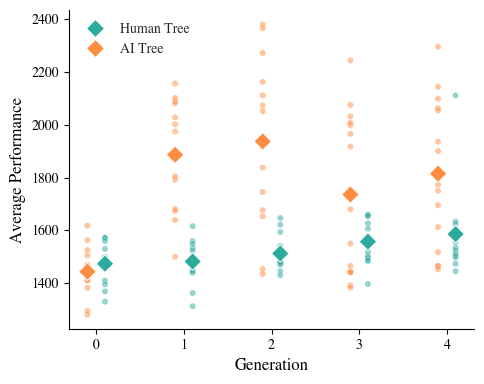

In [8]:
import seaborn as sns


generation_df = player_df.groupby(['replication_idx', 'generation', 'condition', 'ai_player'])['player_score'].mean().reset_index()


plt.figure(figsize=(5, 4))
ax = plt.subplot()
sns.set_theme(style='white', rc={'font.family': 'serif', 'font.serif': ['Times', 'Times New Roman', 'FreeSans']})



generation_df['condition'] = generation_df['condition'].replace({'w_ai': 'AI Tree', 'wo_ai': 'Human Tree'})

generation_df = generation_df[generation_df['ai_player'] == False]


generation_df.loc[generation_df['condition'] == 'AI Tree', 'generation'] = generation_df.loc[generation_df['condition'] == 'AI Tree', 'generation'] - 0.1
generation_df.loc[generation_df['condition'] == 'Human Tree', 'generation'] = generation_df.loc[generation_df['condition'] == 'Human Tree', 'generation'] + 0.1

hue_order = ['Human Tree', 'AI Tree',]

custom_palette = ['#379683', '#E27D60', '#8E8DAA']
# custom_palette = ['#2C7BB6', '#FFA07A', '#97D95C']
custom_palette = ['#2BAA9D', '#FF8C41', '#7F37B6', ]

sns.scatterplot(data=generation_df, x='generation', y='player_score', hue='condition', hue_order=hue_order, s=20, alpha=0.5, ax=ax, legend=False, palette=custom_palette)

generation_mean_df = generation_df.groupby(['generation', 'condition'])['player_score'].mean().reset_index()

sns.scatterplot(data=generation_mean_df, x='generation', y='player_score', hue='condition', hue_order=hue_order, s=80, alpha=1, ax=ax, marker='D', palette=custom_palette)

ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Average Performance', fontsize=12)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(frameon=False, fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)


png_filename = os.path.join('plots',experiment_type,'performance.png')
pdf_filename = os.path.join('plots',experiment_type,'performance.pdf')
os.makedirs(os.path.dirname(file_name), exist_ok=True)
plt.tight_layout()
fig.subplots_adjust(top=0.98, right=0.99)
plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)